## Section D. Ridge Regression


### Question 5 [Ridge Regression]

In [1]:
#install.packages("glmnet")
#install.packages("car")

library(glmnet)   # for regresion models + l1 (LASSO), l2 (Ridge) and l1/l2 (Ealstic Net) regularizations
library(ggplot2)  # for plotting functions.
library(reshape2) # for melt and cast functions

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'reshape2' was built under R version 3.6.3"

1. Given the gradient descent algorithms for linear regression (discussed in
Chapter 2 of Module 2), derive weight update steps of stochastic gradient
descent (SGD) for linear regression with L2 regularisation norm. Show
your work with enough explanation in your PDF report; you should
provide the steps of SGD. 


STEPS: <br>

* Initialize weight w0 and interation index, tau = 1.
* While stepping condition not met
        * (x,y)
        * update : 
\begin{eqnarray} 
w^{(\tau)} := w^{(\tau-1)} – \eta^{(\tau)} \nabla E_n(w^{(\tau-1)})
\end{eqnarray}
        *  tau = tau + 1

Error Function for Stochastics gradient descent (SGD) with L2 regularisation is given as: 
Error function comprises a sum over data points.

        






\begin{eqnarray} 
E(w) = \frac{1}{2}  \sum_{n=1}^N (t_n – w\cdot {\phi}(x_n))^2 + \frac{\lambda}{2}\sum_{j=0}^{M-1} w_j^2
\end{eqnarray}

<br>
<br>
Now that we have the training objective, we need to optimise it to get the best parameter values. To
optimise the training objective, we know from calculus that we need to set the partial derivatives with
respect to all parameters to zero:










\begin{eqnarray} 
dE / dw = \frac{1}{2} \sum_{n=1}^N 2(t_n – w\cdot \phi(x_n))(-\phi(x_n) + \frac{\lambda}{2}\sum_{j=0}^{M-1} 2w_j = 0
\end{eqnarray}







Weights are updated after each time iterating and moving towards negative gradient:


\begin{eqnarray} 
w^{(\tau)} := w^{(\tau-1)} – \eta^{(\tau)} \nabla E_n(w^{(\tau-1)})
\end{eqnarray}



\begin{eqnarray}
w^{(\tau)} :=w^{(\tau-1)} + \eta^{(\tau)}\sum_{n=1}^N((t_n – w\cdot \pmb{\phi}(x_n))(-\pmb{\phi}({x}_n)) - \eta^{(\tau)}{\lambda}\sum_{j=0}^{M-1} w_j
\end{eqnarray}

2. Using R (with no use of special libraries), implement an SGD algorithm that
you derived in Step I. The implementation is straightforward as you are
allowed to use the code examples provided.

In [2]:
# fundtion to read data
read_data <- function(fname, sc) {
   data <- read.csv(file=fname,head=TRUE,sep=",")
   nr = dim(data)[1]
   nc = dim(data)[2]
   x = data[1:nr,1:(nc-1)]
   y = data[1:nr,nc]
   if (isTRUE(sc)) {
      x = scale(x)
      y = scale(y)
   }
   return (list("x" = x, "y" = y))
}

In [3]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w)
} 

In [4]:
# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
    # the L2 regulariser is already included in the objective function for training 
    return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

In [5]:
# auxiliary function to compute the error of the model
get_errors <- function(train_data, test_data, W,lambda) {
   n_weights = dim(W)[1]
   errors = matrix(,nrow=n_weights, ncol=2)
   for (tau in 1:n_weights) {
      errors[tau,1] = train_obj_func(train_data$x, W[tau,],train_data$y, lambda)
      errors[tau,2] = train_obj_func(test_data$x, W[tau,],test_data$y, lambda)
      colnames(errors) = c('training_error','testing_error') 
   }
   return(errors)
}

In [6]:
##--- Stochastic Gradient Descent --------------------------------------------
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

   train_len = dim(train_x)[1]
   tau_max = max_epoch * train_len

   W <- matrix(,nrow=tau_max, ncol=ncol(train_x)) 
   W[1,] <- runif(ncol(train_x))
  
   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=tau_max, ncol=1) 
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   while (tau <= tau_max){
       

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon){
           break
       }
       
       
 
       # shuffle data:
       train_index <- sample(1:train_len, train_len, replace = FALSE)
    
       # loop over each datapoint
       for (i in train_index) {
           # increment the counter
           tau <- tau + 1
           if (tau > tau_max) {break}

           # make the weight update
           y_pred <- predict_func(train_x[i,], W[tau-1,])
           W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)

           # keep track of the objective funtion
           obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
       }
   }
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val,'W'=W))
}

# updating the weight vector
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   L2_reg = (lambda * W_prev)
   grad = - (y_true-y_pred) * x 
   return(W_prev - eta * (grad + L2_reg))
}

In [7]:
# implementation of SGD using sample values for max_epoch, epsilon,eta and lambda.

play_with_sgd <- function(dtrain,dtest) {

   ##### SGD Trainng
   max_epoch = 20
   lambda=0
   epsilon = .001
   eta = .01
   

   train_res = sgd_train(dtrain$x, dtrain$y, lambda, eta, epsilon, max_epoch)
    
   errors = get_errors(dtrain, dtest, train_res$W,lambda) 

   plot(train_res$val, main="SGD", type="l", col="blue", ylim=c(0,.1), xlab="iteration", ylab="training objective function")
}

# options(warn=-1)
# play_with_sgd(train_data,test_data)

3. Now let’s study the effect of the L2 norm regularization on the training and testing errors:

3a. Load Task1C_train.csv and Task1C_test.csv sets.

In [8]:
#Loading train and test data
train_data = read_data("Task1C_train.csv", TRUE)
test_data = read_data("Task1C_test.csv", TRUE)

3b. For each lambda in {0, 0.4, 0.8, …, 10}, build a regression model and
compute the training and testing errors, using the provided data
sets. While building each model, all parameter settings (initial
values, learning rate, etc) are exactly the same, except a lambda
value. Set the termination criterion as maximum of 20 x N weight
updates (where N is the number of training data). Create a plot of
error rates (use different colors for the training and testing errors),
where the x-axis is log lambda and y-axis is the error rate. Save your
plot in your Jupyter Notebook file for Question 5.

In [9]:
play_with_sgd_1 <- function(dtrain,dtest) {
 
   max_epoch = 20
   epsilon = .001
   eta = .01
   lambda_seq = seq(0,10,0.4)
    
   training_err = c()
    
   testing_err = c()
    
   for (i in (1:length(lambda_seq))){
       train_res = sgd_train(dtrain$x, dtrain$y, lambda_seq[i], eta, epsilon, max_epoch)
       errors = as.data.frame(get_errors(dtrain, dtest, train_res$W,lambda_seq[i]))
       
       training_err[i] = mean(errors$training_err)
       testing_err[i] = mean(errors$testing_err)      
   }
   data_1 <- as.data.frame(cbind(training_err,testing_err,lambda_seq))
   data_final = melt(data_1,id='lambda_seq')
    
   ggplot(data=data_final, aes(x=log(lambda_seq), y=value, color=variable)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
       ggtitle("Lambda vs Error Rate ")
}

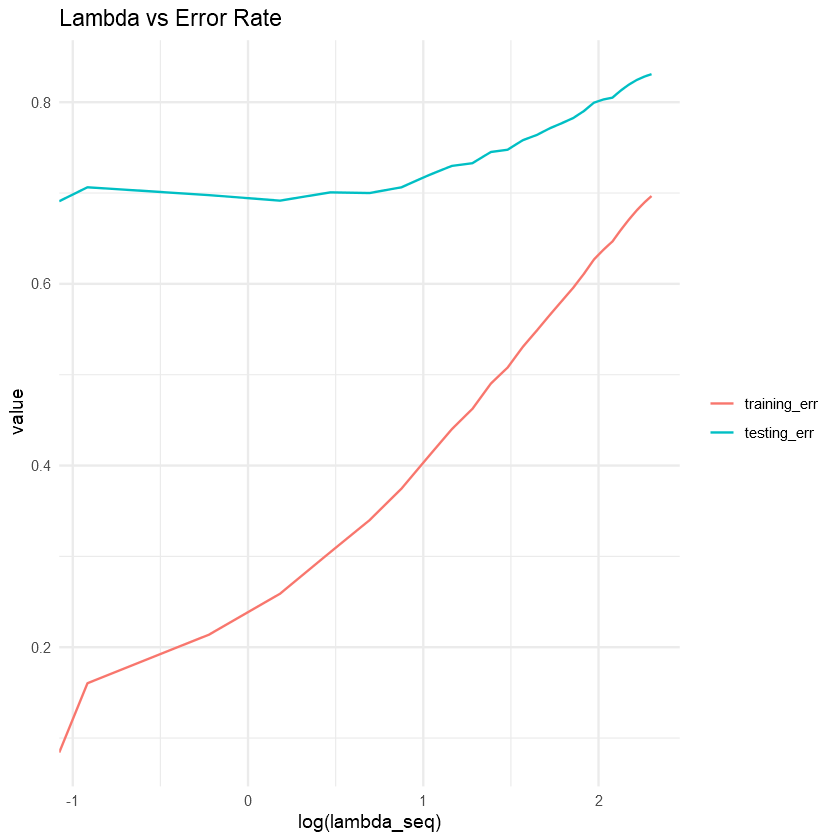

In [10]:
options(warn=-1)
play_with_sgd_1(train_data,test_data)

3c. Based on your plot in the previous part (Part b), what’s the best
value for lambda? Discuss lambda, model complexity, and error
rates, corresponding to underfitting and overfitting, by observing
your plot. (Include all your answers in your Jupyter Notebook file.) 
<br>
 <br>

An ideal value of lambda produces a model that generalises well on the new test data i.e unseen data. <br>
General understanding of lambda values :

* If our lambda value is too high, our model will be pretty simple, but runs the risk of underfitting our data.
* If our lambda value is too low, our model will be more complex, and hence runs the risk of overfitting our data. <br>

Observations from the plot:           In our case lambda  = (0,0.4,0.8, 1.2,....,10 )<br>

* For very small value of lambda i.e near 0, our training error is very low while the test error is very high. This means that our model is overfitting on the train data. Model is very complex and runs the risk of overfitting.

* For values of lambda equal to 10 and higher, both train and test errors are high. This means our model is underfitting on the train data. Model is vsimple and runs the risk of underfitting.

* For log(lambda_val) = 0.2, seems to be an ideal point were both train and test errors seem to be converging the most.

**Both Train and Test errors increase gradually with increasing values of lambda.**

#### Therefore the best value for lambda would be 1.59